In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import tensorflow as tf
from tqdm import tqdm
from glob import glob
from google.colab import drive

import librosa
import librosa.display as dsp
import IPython.display as ipd

warnings.filterwarnings(action='ignore')
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(813)

train = pd.read_csv('/content/drive/MyDrive/drive-download-20220614T024615Z-001/train.csv')
test = pd.read_csv('/content/drive/MyDrive/drive-download-20220614T024615Z-001/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/drive-download-20220614T024615Z-001/sample_submission.csv')

In [ ]:
sr = 22050

In [ ]:
for i in os.listdir('/content/drive/MyDrive/Dacon/train')[:3]:
  print(f'{i}')
  data, sample_rate = librosa.load(f'/content/drive/MyDrive/Dacon/train/{i}', sr=sr)
  print('sample_rate:', sample_rate, ', audio shape:', data.shape)
  print('length:', data.shape[0]/float(sample_rate), 'secs')
  print('\n')

012.wav
sample_rate: 22050 , audio shape: (11910,)
length: 0.5401360544217687 secs


001.wav
sample_rate: 22050 , audio shape: (14046,)
length: 0.6370068027210884 secs


005.wav
sample_rate: 22050 , audio shape: (10753,)
length: 0.48766439909297055 secs




In [ ]:
from tqdm.notebook import tqdm

train_file_names = train["file_name"].to_numpy()
test_file_names = test["file_name"].to_numpy()
target = train["label"].to_numpy()

def load_audio(file_names, target, path):   
  audios = []
  for audio in tqdm(file_names):
    # librosa를 이용하여 데이터 로드
    an_audio, _ = librosa.load(path+audio, sr=sr)
    audio_array = np.array(an_audio)
    audios.append(audio_array)
  audios = np.array(audios)

  targets = target.copy()

  return audios, targets


In [ ]:
audio_train, target_train = load_audio(train_file_names, target, path='/content/drive/MyDrive/Dacon/train/')
audio_test, _ = load_audio(test_file_names, np.array([None]), path='/content/drive/MyDrive/test/')

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

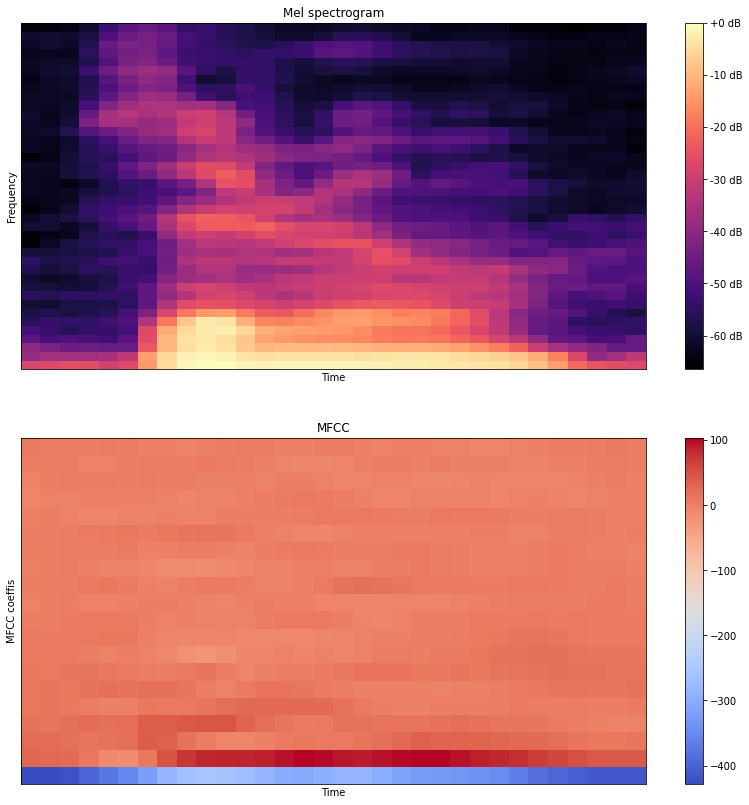

In [ ]:
plt.figure(figsize=(14,14))
ax = plt.subplot(2, 1, 1)


ax = plt.subplot(2, 1, 1)
S = librosa.feature.melspectrogram(audio_train[15], sr=sr, n_mels=40)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=sr)
plt.title('Mel spectrogram')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

ax = plt.subplot(2, 1, 2)
mfcc = librosa.feature.mfcc(audio_train[15], sr=sr, n_mels=40)
librosa.display.specshow(mfcc, sr=sr)
plt.title('MFCC')
plt.xlabel("Time")
plt.ylabel("MFCC coeffis")
plt.colorbar()

In [ ]:
def random_pad(mels, pad_size, mfcc=True):

  pad_width = pad_size - mels.shape[1]
  rand = np.random.rand()
  left = int(pad_width * rand)
  right = pad_width - left
  
  if mfcc:
    mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min)/(local_max - local_min)
  else:
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min)/(local_max - local_min)
    mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')


  return mels

In [ ]:
size = 50
pad_size = 50
repeat_size = 5

In [ ]:
audio_mels = []
audio_mfcc = []

for y in audio_train:
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
  mels = librosa.power_to_db(mels, ref=np.max)

  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)
  
  for i in range(repeat_size):
    audio_mels.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    audio_mfcc.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

In [ ]:
audio_mels_array_test = []
audio_mfcc_array_test = []

for y in audio_test:
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
  mels = librosa.power_to_db(mels, ref=np.max)


  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)

  audio_mels_array_test.append(random_pad(mels, pad_size=pad_size, mfcc=False))
  audio_mfcc_array_test.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

In [ ]:
audio_mels_array = np.array(audio_mels, np.float64)
audio_mfcc_array = np.array(audio_mfcc, np.float64)

audio_mels_array_test = np.array(audio_mels_array_test, np.float64)
audio_mfcc_array_test = np.array(audio_mfcc_array_test, np.float64)

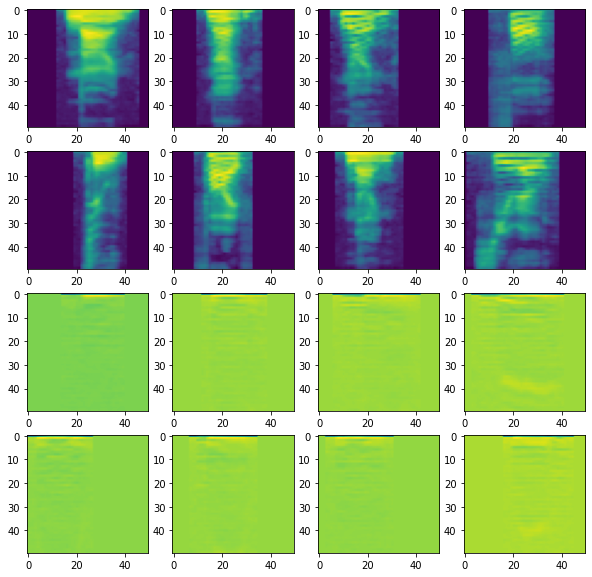

In [ ]:
target_num = 2
target_num_idx = np.where(target_train==target_num)[0]
target_num_idx = np.random.choice(target_num_idx,16)

plt.figure(figsize=(10, 10))
ax = plt.subplot(4, 4, 1)

for i, idx in enumerate(target_num_idx):
  ax = plt.subplot(4, 4, i + 1)
  if i<8:
    plt.imshow(audio_mels_array[idx], aspect='auto')
  else:
    plt.imshow(audio_mfcc_array[idx], aspect='auto')


In [ ]:
from sklearn.model_selection import train_test_split

repeated_target = np.repeat(target_train,repeat_size)

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D, ZeroPadding2D, BatchNormalization, Input, DepthwiseConv2D, Add, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
def residual_block(x, filters_in, filters_out):
    shortcut = x
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters_in, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(filters_in, kernel_size=(3, 3), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)  
    x = Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    shortcut_channel = x.shape.as_list()[0]
    
    if shortcut_channel != filters_out:
        shortcut = Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(shortcut)
        
    x = Add()([x, shortcut])
    return ReLU()(x)

In [ ]:
def build_model():

  inputs = tf.keras.layers.Input(shape=(size,pad_size,1))

  outputs = Conv2D(16,(3,3),activation=None,padding='same',kernel_initializer='he_normal')(inputs)
  outputs = BatchNormalization()(outputs)
  outputs = ReLU()(outputs)
  outputs = MaxPool2D((2,2))(outputs)

  outputs = residual_block(outputs, 16, 32)
  outputs = MaxPool2D((2,2))(outputs)
  outputs = residual_block(outputs, 32, 32)
  # outputs = residual_block(outputs, 32, 32)
  outputs = residual_block(outputs, 32, 64)
  outputs = MaxPool2D((2,2))(outputs)
  outputs = residual_block(outputs, 64, 64)
  # outputs = residual_block(outputs, 64, 64)
  # outputs = MaxPool2D((2,2))(outputs)

  outputs = GlobalAveragePooling2D()(outputs)
  # outputs = Flatten()(outputs)

  outputs = Dense(32,activation=None,kernel_initializer='he_normal')(outputs)
  outputs = BatchNormalization()(outputs)
  outputs = ReLU()(outputs)
  outputs = Dropout(0.5)(outputs)

  outputs = Dense(10,activation='softmax')(outputs)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 16)   160         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 50, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 50, 50, 16)   0           ['batch_normalization[0][0]']

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

acc_list = []
pred_list = []
skf = StratifiedKFold(n_splits=5)

for fold,(train_index, val_index) in enumerate(skf.split(audio_mels_array, repeated_target)):

  print(f'\n********** {fold+1} fold **********')

  preds_val_list = []
  ### melspectrogram ###
  model = build_model()
  x_train, x_val, y_train, y_val = audio_mels_array[train_index], audio_mels_array[val_index], repeated_target[train_index], repeated_target[val_index]
  filepath = f"model.res_test_0615_mels_{fold}.hdf5"
  callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')]
  history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), callbacks=callbacks, verbose=0)
  model = load_model(filepath)

  preds_val = model.predict(x_val)
  preds_val_list.append(preds_val)
  preds_val_label = np.argmax(preds_val, axis=1)
  pred_list.append(model.predict(audio_mels_array_test))
  print(f'mels_model_acc : {accuracy_score(y_val,preds_val_label):.4f}')

  ### mfcc ###
  model = build_model()
  x_train, x_val, y_train, y_val = audio_mfcc_array[train_index], audio_mfcc_array[val_index], repeated_target[train_index], repeated_target[val_index]
  filepath = f"model.res_test_0615_mfcc_{fold}.hdf5"
  callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')]
  history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), callbacks=callbacks, verbose=0)
  model = load_model(filepath)

  preds_val = model.predict(x_val)
  preds_val_list.append(preds_val)
  preds_val_label = np.argmax(preds_val, axis=1)
  pred_list.append(model.predict(audio_mfcc_array_test))
  print(f'mfcc_model_acc : {accuracy_score(y_val,preds_val_label):.4f}')

  ### ensemble ###
  val_pred_result = preds_val_list[0].copy()
  for i in range(1, len(preds_val_list)):
      val_pred_result += preds_val_list[i]
  val_pred_label = np.argmax(val_pred_result, axis=1)
  en_acc = accuracy_score(y_val,val_pred_label)
  acc_list.append(en_acc)
  print(f'ensemble_model_acc : {en_acc:.4f}')

print(f'\n\nmean_acc : {np.mean(acc_list):.4f}')


********** 1 fold **********
mels_model_acc : 0.9925
mfcc_model_acc : 0.9600
ensemble_model_acc : 0.9925

********** 2 fold **********
mels_model_acc : 0.9450
mfcc_model_acc : 0.9225
ensemble_model_acc : 0.9575

********** 3 fold **********
mels_model_acc : 0.9575
mfcc_model_acc : 0.9600
ensemble_model_acc : 0.9775

********** 4 fold **********
mels_model_acc : 0.9250
mfcc_model_acc : 0.9550
ensemble_model_acc : 0.9725

********** 5 fold **********
mels_model_acc : 0.9250
mfcc_model_acc : 0.9300
ensemble_model_acc : 0.9650


mean_acc : 0.9730


In [ ]:
test_pred_result = pred_list[0].copy()
for i in range(1, len(pred_list)):
    test_pred_result += pred_list[i]

submission['label'] = np.argmax(test_pred_result, axis=1)
submission.head()
submission.to_csv('./CNN.csv', index=False) 